# Potwierdzam samodzielność powyższej pracy oraz niekorzystanie przeze mnie z niedozwolonych źródeł. Olaf Werner

In [693]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import RegularPolygon
import matplotlib.cm as cm
from sklearn.decomposition import PCA

In [694]:
np.random.seed(123)

In [695]:
def gaussian(d,t):
    d=d*t
    return np.exp(-(d**2))

In [696]:
def mexican_hat(d,t):
    d=d*t*3
    return (2-4*d**2)*np.exp(-(d**2))

In [697]:
def exp_res(t,lambd):
    return np.exp(-t/lambd)

In [698]:
class Kohen:
    def __init__(self,M,N):
        self.Neurons=[[0]*N for x in range(M)]
        
    def euclidean(self,x,y):
        return np.sqrt(np.sum((x-y)**2))
    
    def train(self,Data,lambd,neighbour_fun,learning_res,scale_x=1,scale_y=1,hexagon_grid=False,seed=123):
        #initaite with random vectors
        np.random.seed(seed)
        for x in range(len(self.Neurons)):
            for y in range(len(self.Neurons[0])):
                self.Neurons[x][y]=np.random.random(Data.shape[1])*2-1
                
        for s in range(1,lambd):
            for t in range(Data.shape[0]):
                #find BMU
                D=Data[t]
                BMU_x=0
                BMU_y=0
                BMU_value=self.euclidean(self.Neurons[BMU_x][BMU_y],D)
                for x in range(len(self.Neurons)):
                    for y in range(len(self.Neurons[0])):
                        D_t=self.euclidean(self.Neurons[x][y],D)
                        if D_t<BMU_value:
                            BMU_value=D_t
                            BMU_x=x
                            BMU_y=y
                            
                #update
                for x in range(len(self.Neurons)):
                    for y in range(len(self.Neurons[0])):
                        if hexagon_grid:
                            d=np.sqrt(((y-BMU_y)*1.5*scale_y)**2+3*(((BMU_x+BMU_y//2)-(x+y//2)-(y-BMU_y)/2)*scale_x)**2)
                            
                        else:
                            d=np.sqrt((scale_x*(x-BMU_x))**2+(scale_y*(y-BMU_y))**2)
                        
                        self.Neurons[x][y]=self.Neurons[x][y]+neighbour_fun(d,s)*learning_res(s,lambd)*(D-self.Neurons[x][y])
                
    def hexagonal_cord(self,Data):
        d=Data.copy()
        d[:,0]=d[:,0]+d[:,1]//2
        output=output=np.zeros((Data.shape[0],3))
        output[:,0]=d[:,0]
        output[:,1]=d[:,1]-d[:,0]
        output[:,2]=-d[:,1]
        return output
    
    def map_input(self,Data):
        output=np.zeros((Data.shape[0],2))
        
        for t in range(Data.shape[0]):
            #find BMU
            D=Data[t]
            BMU_x=0
            BMU_y=0
            BMU_value=self.euclidean(self.Neurons[BMU_x][BMU_y],D)
            for x in range(len(self.Neurons)):
                for y in range(len(self.Neurons[0])):
                    D_t=self.euclidean(self.Neurons[x][y],D)
                    if D_t<BMU_value:
                        BMU_value=D_t
                        BMU_x=x
                        BMU_y=y
            output[t,0]=BMU_x
            output[t,1]=BMU_y
            
        return output
    
    def map_umatrix_hex(self,statistic="mean"):
        output=np.zeros((len(self.Neurons)*2-1,len(self.Neurons[0])*2-1))
        for x in range(len(self.Neurons)):
            for y in range(len(self.Neurons[0])):
                d=[]
                for i in range(-1,2):
                    for j in range(-1,2):
                        if 0<=(x+i)<(len(self.Neurons)) and 0<=(x+i)+y//2-(y+j)//2<(len(self.Neurons)) and 0<=y+j<len(self.Neurons[0]) and not(j==0 and i==0):
                            temp=self.euclidean(self.Neurons[x+i][y+j],self.Neurons[x][y])
                            output[2*x+i,2*y+j]=temp
                            d.append(temp)
                if statistic=="mean":
                    output[2*x,2*y]=np.mean(d)
                if statistic=="min":
                    output[2*x,2*y]=np.min(d)
                if statistic=="median":
                    output[2*x,2*y]=np.median(d)
                if statistic=="max":
                    output[2*x,2*y]=np.max(d)
            
        return output
    
    def map_umatrix(self,statistic="mean"):
        output=np.zeros((len(self.Neurons)*2-1,len(self.Neurons[0])*2-1))
        for x in range(len(self.Neurons)):
            for y in range(len(self.Neurons[0])):
                d=[]
                for i in range(-1,2):
                    for j in range(-1,2):
                        if 0<=2*x+i<2*len(self.Neurons)-1 and 0<=2*y+j<2*len(self.Neurons[0])-1 and not (x+i==x and y+j==y):
                            temp=self.euclidean(self.Neurons[x+i][y+j],self.Neurons[x][y])
                            output[2*x+i,2*y+j]=temp
                            d.append(temp)
                if statistic=="mean":
                    output[2*x,2*y]=np.mean(d)
                if statistic=="min":
                    output[2*x,2*y]=np.min(d)
                if statistic=="median":
                    output[2*x,2*y]=np.median(d)
                if statistic=="max":
                    output[2*x,2*y]=np.max(d)
                    
        for x in range(len(self.Neurons)-1):
            for y in range(len(self.Neurons[0])-1):
                
                if statistic=="mean":
                    output[2*x+1,2*y+1]=np.mean([output[2*x,2*y+1],output[2*x+2,2*y+1],output[2*x+1,2*y],output[2*x+1,2*y+2]])
                if statistic=="min":
                    output[2*x+1,2*y+1]=np.min([output[2*x,2*y+1],output[2*x+2,2*y+1],output[2*x+1,2*y],output[2*x+1,2*y+2]])
                if statistic=="median":
                    output[2*x+1,2*y+1]=np.median([output[2*x,2*y+1],output[2*x+2,2*y+1],output[2*x+1,2*y],output[2*x+1,2*y+2]])
                if statistic=="max":
                    output[2*x+1,2*y+1]=np.max([output[2*x,2*y+1],output[2*x+2,2*y+1],output[2*x+1,2*y],output[2*x+1,2*y+2]])
        
        
            
        return output
    
    def map_distance(self,statistic="mean"):
        output=np.zeros((len(self.Neurons),len(self.Neurons[0])))
        for x in range(len(self.Neurons)):
            for y in range(len(self.Neurons[0])):
                d=[]
                for i in range(-1,2):
                    for j in range(-1,2):
                        if 0<=x+i<len(self.Neurons) and 0<=y+j<len(self.Neurons[0]) and not (x+i==x and y+j==y):
                            temp=self.euclidean(self.Neurons[x+i][y+j],self.Neurons[x][y])
                            d.append(temp)
                if statistic=="mean":
                    output[x,y]=np.mean(d)
                if statistic=="min":
                    output[x,y]=np.min(d)
                if statistic=="median":
                    output[x,y]=np.median(d)
                if statistic=="max":
                    output[2*x,2*y]=np.max(d)
            
        return output

# Wstęp

Zbadamy działanie sieci Kohena na dwóch zbiorach danych: MNIST i UCI HAR. Będziemy testować w zależności od architektury sieci (sześciokątnej i kwadratowej) oraz funkcji sąsiedztwa: gaussowskiej i minus drugiej pochodnej funkcji gaussowskiej dalej zwaną "sombrero". Sombrero jest wygaszana 3 razy szybciej. Funkcją wygasającą będzie wykładnicza. Początkowe wagi neuronów będą losowane jednostajnie na przedziale [-1,1] i będą takie same dla wszystkich sieci w ramach danego zbioru danych. Weżmiemy architekturę 4 na 4 i będziemy trenować na losowym podzbiorzę o wielkości 1/10 oryginalnego. Będziemy mieli 100 iteracji.

# MNIST

Normalizujemy dane poprzez podzielenie na 255, pomnożenie przez dwa i odjęcie 1.

In [699]:
test = np.loadtxt("MNIST/mnist_train.csv", delimiter=',', skiprows=1)
np.random.shuffle(test)
X=test[:,1:]
Y=test[:,0:1]
X=(X/255)*2-1

In [700]:
test = np.loadtxt("MNIST/mnist_test.csv", delimiter=',', skiprows=1)
np.random.shuffle(test)
X_t=test[:,1:]
Y_t=test[:,0:1]
X_t=(X_t/255)*2-1

## Sześciokątna i gaussowska

In [701]:
Map_hex_gauss=Kohen(4,4)

Map_hex_gauss.train(X[::10,:],100,gaussian,exp_res,hexagon_grid=True)

map_neurons=Map_hex_gauss.map_input(X_t)

test=pd.DataFrame(map_neurons,columns=["map_x","map_y"])

test["map_x_r"]=map_neurons[:,0]+(np.random.random(test.shape[0])*2-1)/3

test["map_y_r"]=map_neurons[:,1]+(np.random.random(test.shape[0])*2-1)/3

test["c"]=Y_t[:,0].astype(int).astype(str)

t1_hex_gauss=test.groupby(["map_x","map_y"])["c"].agg(lambda x:x.value_counts().index[0]).reset_index()

t2=test.groupby(["map_x","map_y"])["c"].agg(lambda x:x.value_counts().nlargest(n=1).values[0]).reset_index()

t3=test.groupby(["map_x","map_y"])["c"].size().reset_index()

t1_hex_gauss["freq"]=t2.c/t3.c
t1_hex_gauss["size"]=t3.c

## Klasa i BMU dla każdej obserwacji testowej

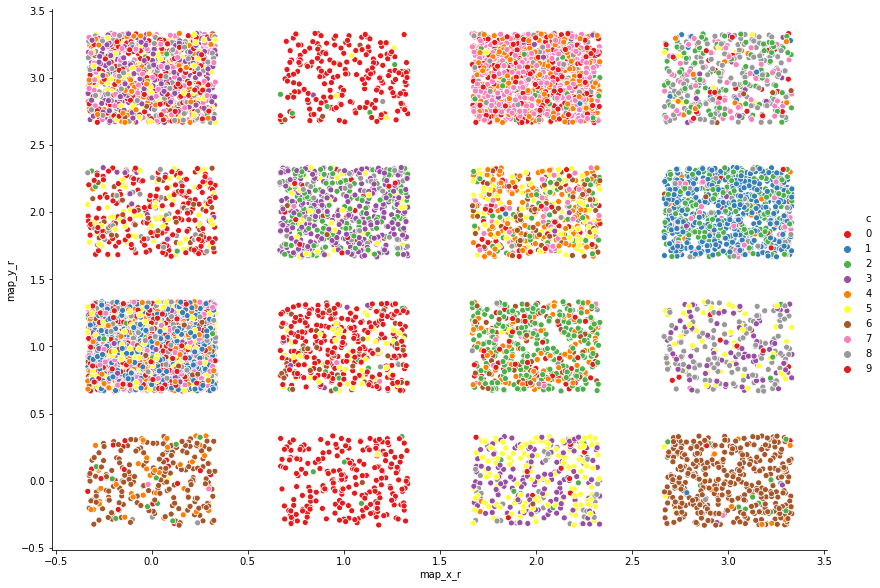

In [702]:
sns.relplot(x="map_x_r",y="map_y_r",hue="c",data=test,kind="scatter",palette=sns.color_palette("Set1", 10), height=8.27, aspect=11.7/8.27)

Widzimy że nasza sieć dobrze dopasowywuje się do 0 i 6 reszta klastrów jest mocno wymieszana.

## Czystość w zależności od neuronu

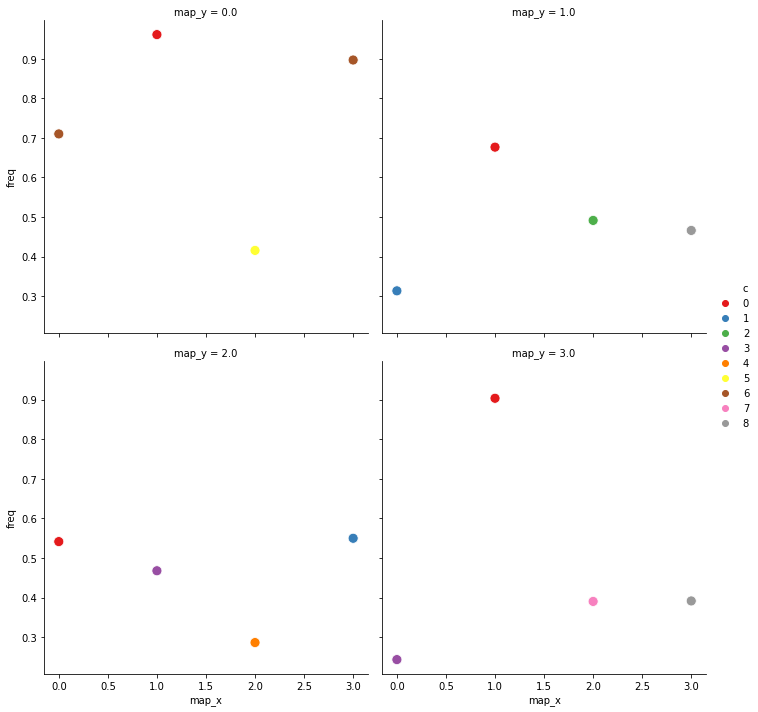

In [703]:
sns.relplot(x="map_x",y="freq",hue="c",col="map_y",data=t1_hex_gauss,kind="scatter",palette=sns.color_palette("Set1", t1_hex_gauss.c.unique().shape[0]), s=100,col_wrap=2)

Tutaj i w dalszych wykresach czystość rozumiemy jako częstość występowania najczęściej występującej klasy. Ten wykres potwierdza nasze przypuszczenia o dobrym dopasowaniu 0 i 6, reszta jest dopasowana lepiej niż losowo, oprócz neuronu [0,3] który ma słabe rezultaty. 

## U Macierz

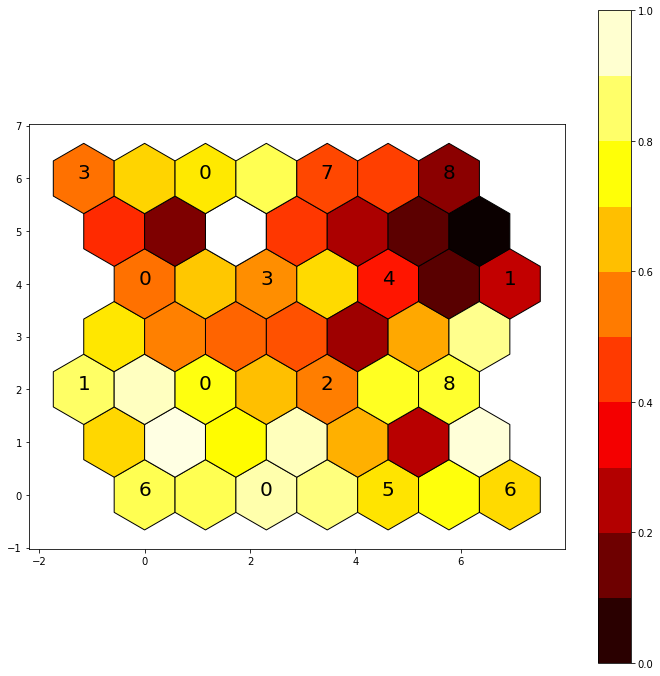

In [704]:
output=np.zeros(((2*len(Map_hex_gauss.Neurons)-1)*(2*len(Map_hex_gauss.Neurons[0])-1),2))
i=0
for x in range((2*len(Map_hex_gauss.Neurons)-1)):
        for y in range((2*len(Map_hex_gauss.Neurons[0])-1)):
            output[i,0]=x
            output[i,1]=y
            i+=1

output[output[:,1]%7==2,0]=output[output[:,1]%7==2,0]-1

output[output[:,1]%7==6,0]=output[output[:,1]%7==6,0]-1
            
hexy=Map_hex_gauss.hexagonal_cord(output)

kolor=Map_hex_gauss.map_umatrix_hex()

kolor=kolor.reshape(1,-1)[0]

numbers=t1_hex_gauss[["map_x","map_y"]].to_numpy()*2

numbers[numbers[:,1]%7==2,0]=numbers[numbers[:,1]%7==2,0]-1

numbers[numbers[:,1]%7==6,0]=numbers[numbers[:,1]%7==6,0]-1

numbers=Map_hex_gauss.hexagonal_cord(numbers)

coord = hexy
colors = kolor

colors=(colors-np.min(colors))/(np.max(colors)-np.min(colors))

# Horizontal cartesian coords
hcoord = [c[0] for c in coord]

# Vertical cartersian coords
vcoord = [2. * np.sin(np.radians(60)) * (c[1] - c[2]) /3. for c in coord]

hcoord2=[np.cos(np.radians(-30))*hcoord[x]+np.sin(np.radians(-30))*vcoord[x] for x in range(len(hcoord))]
vcoord2=[-np.sin(np.radians(-30))*hcoord[x]+np.cos(np.radians(-30))*vcoord[x] for x in range(len(hcoord))]

hcoord=hcoord2
vcoord=vcoord2

fig, ax = plt.subplots(1,figsize=(12,12))
ax.set_aspect('equal')
  
# Add some coloured hexagons
for x, y, c in zip(hcoord, vcoord, colors):
    color = cm.hot(c) # matplotlib understands lower case words for colours
    hex = RegularPolygon((x, y), numVertices=6, radius=2. / 3., 
                         orientation=np.radians(60), 
                         facecolor=color, edgecolor='k')
    ax.add_patch(hex)

ax.scatter(hcoord, vcoord, c=[cm.hot(c) for c in colors])

coord = numbers
# Horizontal cartesian coords
hcoord = [c[0] for c in coord]
# Vertical cartersian coords
vcoord = [2. * np.sin(np.radians(60)) * (c[1] - c[2]) /3. for c in coord]

hcoord2=[np.cos(np.radians(-30))*hcoord[x]+np.sin(np.radians(-30))*vcoord[x] for x in range(len(hcoord))]
vcoord2=[-np.sin(np.radians(-30))*hcoord[x]+np.cos(np.radians(-30))*vcoord[x] for x in range(len(hcoord))]

hcoord=hcoord2
vcoord=vcoord2
i=0
for x, y in zip(hcoord, vcoord):
    ax.text(x, y+0.1, t1_hex_gauss.c[i], ha='center', va='center', size=20)
    i+=1

sm = plt.cm.ScalarMappable(cmap=cm.hot)
sm.set_array([])
plt.colorbar(sm, boundaries=np.arange(0,1.1,.1))


Liczby oznaczają tutaj najczęściej występującą klasę, zaś im ciemniejszy obszar tym bliżej siebie są dane klasy. Tu widzimy że 0 i 6 są bardzo dobrze rozdzielane od innych klas. To znaczy że ich neurony są znacząco inne od innych neuronów. Inne są bardziej do siebie podobne co tłumaczy ich niższą czystość.

## Sześciokątna i sombrero

In [705]:
Map_hex_sombrero=Kohen(4,4)

Map_hex_sombrero.train(X[::10,:],100,mexican_hat,exp_res,hexagon_grid=True)

map_neurons=Map_hex_sombrero.map_input(X_t)

test1=pd.DataFrame(map_neurons,columns=["map_x","map_y"])

test1["map_x_r"]=map_neurons[:,0]+(np.random.random(test.shape[0])*2-1)/3

test1["map_y_r"]=map_neurons[:,1]+(np.random.random(test.shape[0])*2-1)/3

test1["c"]=Y_t[:,0].astype(int).astype(str)

t1_hex_sombrero=test1.groupby(["map_x","map_y"])["c"].agg(lambda x:x.value_counts().index[0]).reset_index()

t2=test1.groupby(["map_x","map_y"])["c"].agg(lambda x:x.value_counts().nlargest(n=1).values[0]).reset_index()

t3=test1.groupby(["map_x","map_y"])["c"].size().reset_index()

t1_hex_sombrero["freq"]=t2.c/t3.c
t1_hex_sombrero["size"]=t3.c

## Klasa i BMU dla każdej obserwacji testowej

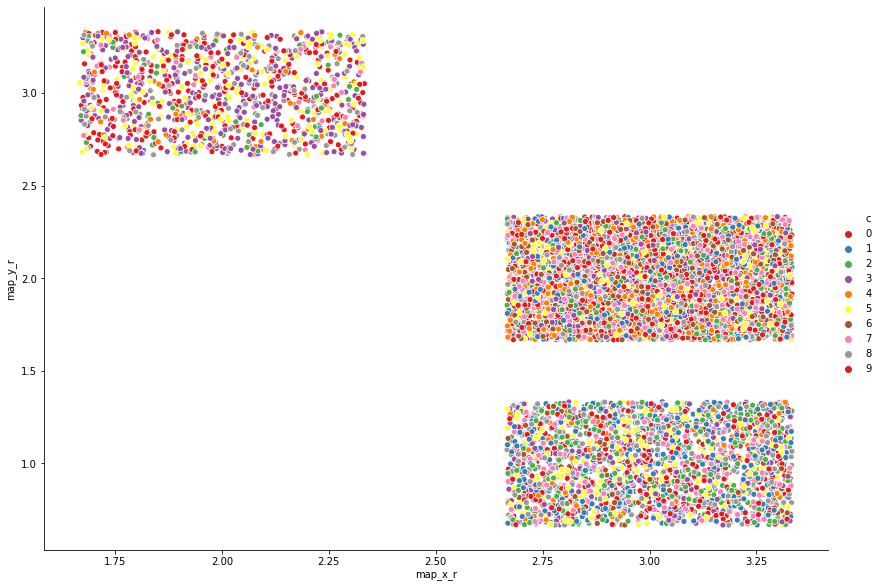

In [706]:
sns.relplot(x="map_x_r",y="map_y_r",hue="c",data=test1,kind="scatter",palette=sns.color_palette("Set1", 10), height=8.27, aspect=11.7/8.27)

Mamy mniej klastrów niż klas to jest bardzo źle.

## Czystość w zależności od neuronu

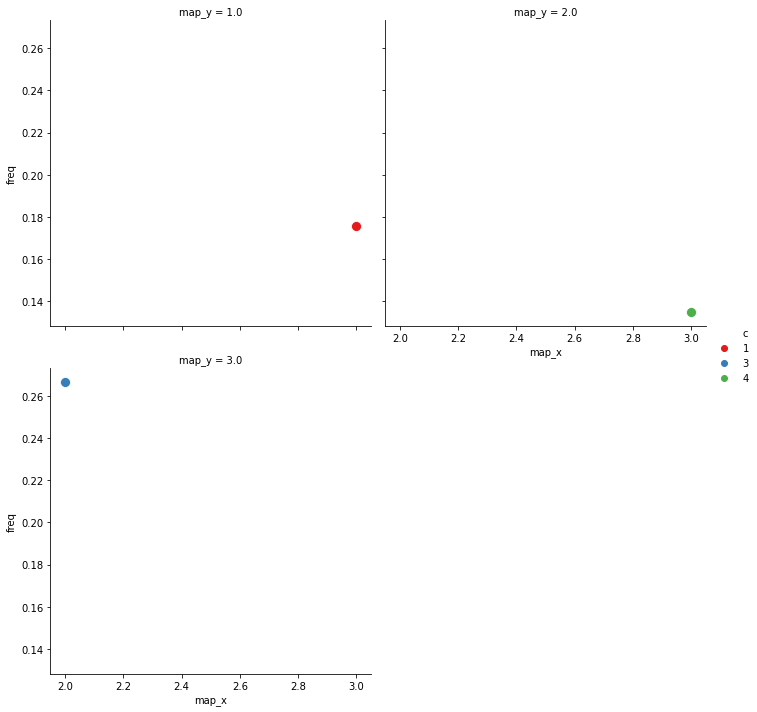

In [707]:
sns.relplot(x="map_x",y="freq",hue="c",col="map_y",data=t1_hex_sombrero,kind="scatter",palette=sns.color_palette("Set1", t1_hex_sombrero.c.unique().shape[0]), s=100,col_wrap=2)

Oprócz 3 to inne liczby są prawie losowe.

## U Macierz

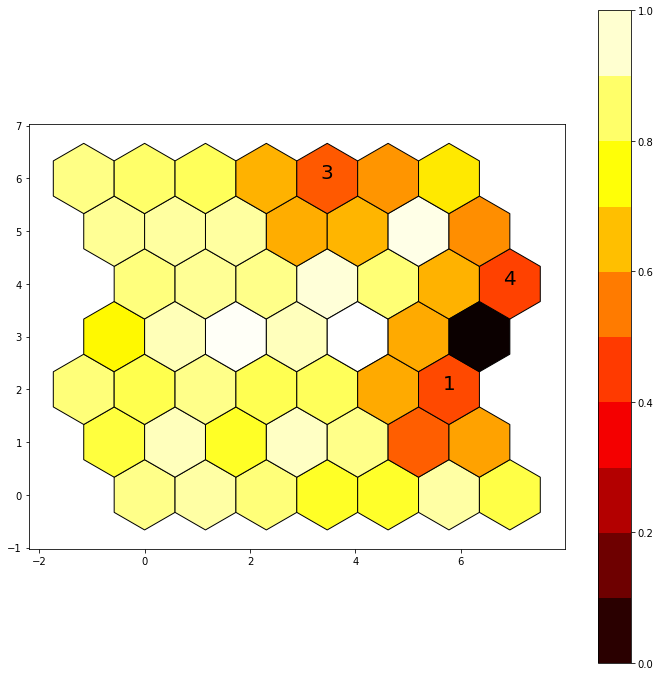

In [708]:
output=np.zeros(((2*len(Map_hex_sombrero.Neurons)-1)*(2*len(Map_hex_sombrero.Neurons[0])-1),2))
i=0
for x in range((2*len(Map_hex_sombrero.Neurons)-1)):
        for y in range((2*len(Map_hex_sombrero.Neurons[0])-1)):
            output[i,0]=x
            output[i,1]=y
            i+=1

output[output[:,1]%7==2,0]=output[output[:,1]%7==2,0]-1

output[output[:,1]%7==6,0]=output[output[:,1]%7==6,0]-1
            
hexy=Map_hex_sombrero.hexagonal_cord(output)

kolor=Map_hex_sombrero.map_umatrix_hex()

kolor=kolor.reshape(1,-1)[0]

numbers=t1_hex_sombrero[["map_x","map_y"]].to_numpy()*2

numbers[numbers[:,1]%7==2,0]=numbers[numbers[:,1]%7==2,0]-1

numbers[numbers[:,1]%7==6,0]=numbers[numbers[:,1]%7==6,0]-1

numbers=Map_hex_sombrero.hexagonal_cord(numbers)

coord = hexy
colors = kolor

colors=(colors-np.min(colors))/(np.max(colors)-np.min(colors))

# Horizontal cartesian coords
hcoord = [c[0] for c in coord]

# Vertical cartersian coords
vcoord = [2. * np.sin(np.radians(60)) * (c[1] - c[2]) /3. for c in coord]

hcoord2=[np.cos(np.radians(-30))*hcoord[x]+np.sin(np.radians(-30))*vcoord[x] for x in range(len(hcoord))]
vcoord2=[-np.sin(np.radians(-30))*hcoord[x]+np.cos(np.radians(-30))*vcoord[x] for x in range(len(hcoord))]

hcoord=hcoord2
vcoord=vcoord2

fig, ax = plt.subplots(1,figsize=(12,12))
ax.set_aspect('equal')
  
# Add some coloured hexagons
for x, y, c in zip(hcoord, vcoord, colors):
    color = cm.hot(c) # matplotlib understands lower case words for colours
    hex = RegularPolygon((x, y), numVertices=6, radius=2. / 3., 
                         orientation=np.radians(60), 
                         facecolor=color, edgecolor='k')
    ax.add_patch(hex)

ax.scatter(hcoord, vcoord, c=[cm.hot(c) for c in colors])

coord = numbers
# Horizontal cartesian coords
hcoord = [c[0] for c in coord]
# Vertical cartersian coords
vcoord = [2. * np.sin(np.radians(60)) * (c[1] - c[2]) /3. for c in coord]

hcoord2=[np.cos(np.radians(-30))*hcoord[x]+np.sin(np.radians(-30))*vcoord[x] for x in range(len(hcoord))]
vcoord2=[-np.sin(np.radians(-30))*hcoord[x]+np.cos(np.radians(-30))*vcoord[x] for x in range(len(hcoord))]

hcoord=hcoord2
vcoord=vcoord2
i=0
for x, y in zip(hcoord, vcoord):
    ax.text(x, y+0.1, t1_hex_sombrero.c[i], ha='center', va='center', size=20)
    i+=1

sm = plt.cm.ScalarMappable(cmap=cm.hot)
sm.set_array([])
plt.colorbar(sm, boundaries=np.arange(0,1.1,.1))


Umacierz wyjaśnia co się stało. Neuron liczby 3 jest w miarę odizolowany od neuronów 4 i 1 które są bardzo blisko siebie co tłumaczy czemu 3 było w miarę czystę, zaś 4 i 1 nie. Pozostałe neurony są bardzo daleko od siebie nawzajem i naszych "działających" wynika to z tego że sombrero może dawać ujemne wartości przez co w trakcie uczenia neurony są "odpychane" od BMU. 

## Kwadratowa i gaussowska

In [709]:
Map_square_gauss=Kohen(4,4)

Map_square_gauss.train(X[::10,:],100,gaussian,exp_res,hexagon_grid=False)

map_neurons=Map_square_gauss.map_input(X_t)

test2=pd.DataFrame(map_neurons,columns=["map_x","map_y"])

test2["map_x_r"]=map_neurons[:,0]+(np.random.random(test.shape[0])*2-1)/3

test2["map_y_r"]=map_neurons[:,1]+(np.random.random(test.shape[0])*2-1)/3

test2["c"]=Y_t[:,0].astype(int).astype(str)

t1_square_gauss=test2.groupby(["map_x","map_y"])["c"].agg(lambda x:x.value_counts().index[0]).reset_index()

t2=test2.groupby(["map_x","map_y"])["c"].agg(lambda x:x.value_counts().nlargest(n=1).values[0]).reset_index()

t3=test2.groupby(["map_x","map_y"])["c"].size().reset_index()

t1_square_gauss["freq"]=t2.c/t3.c
t1_square_gauss["size"]=t3.c

## Klasa i BMU dla każdej obserwacji testowej

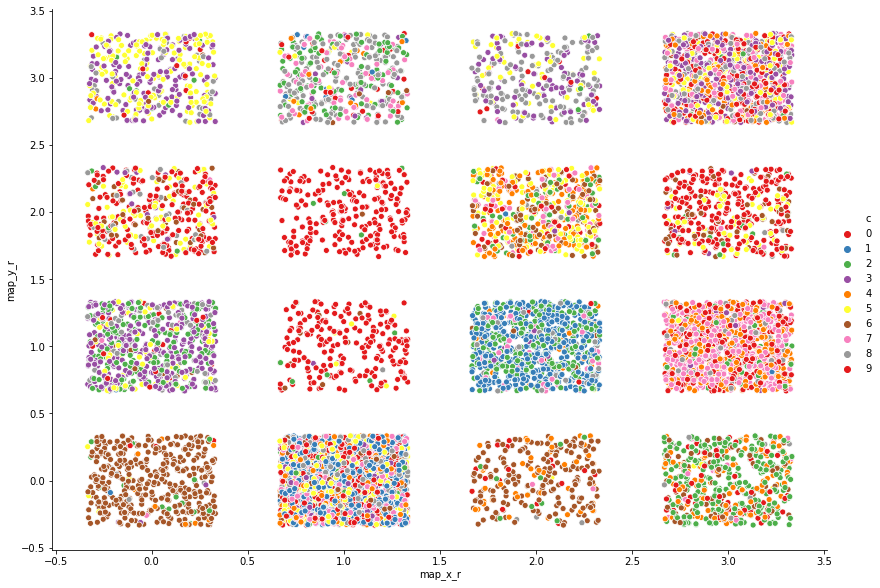

In [710]:
sns.relplot(x="map_x_r",y="map_y_r",hue="c",data=test2,kind="scatter",palette=sns.color_palette("Set1", 10), height=8.27, aspect=11.7/8.27)

Sieć dała podobne rezultaty co ta o architekturzę sześciokątnej czyli 0 i 6 są dobrze separowane, reszta nie jest tak czysta.

## Czystość w zależności od neuronu

<Figure size 1800x2880 with 0 Axes>

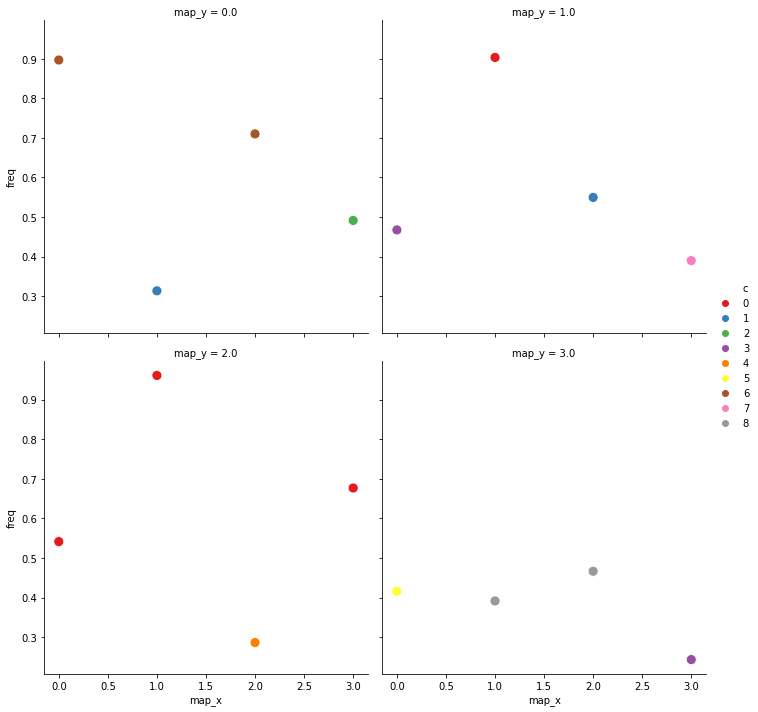

In [711]:
plt.figure(figsize=(25,40))
sns.relplot(x="map_x",y="freq",hue="c",col="map_y",data=t1_square_gauss,kind="scatter",palette=sns.color_palette("Set1", t1_square_gauss.c.unique().shape[0]), s=100,col_wrap=2)

Tutaj 9 też nigdzie nie jest najczęściej występującą wartością. 6 i 0 też są najlepsze.

## U Macierz

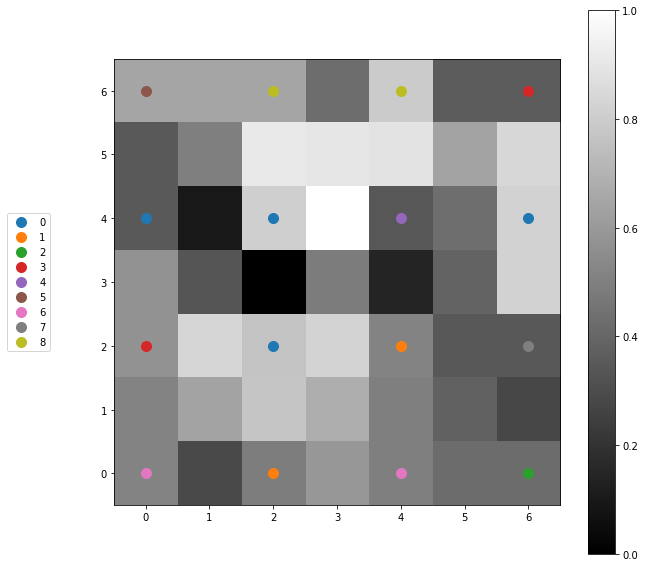

In [712]:
plt.figure(figsize=(10,10))
plt.gray()
plt.imshow(Map_square_gauss.map_umatrix(statistic="median").T)
for i in np.sort(t1_square_gauss.c.unique()):
    plt.scatter(t1_square_gauss[t1_square_gauss.c==i].map_x.to_numpy()*2,t1_square_gauss[t1_square_gauss.c==i].map_y.to_numpy()*2,s=100,label=i)
plt.legend(loc='center left', bbox_to_anchor=(-0.25, 0.5)) 
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

Im ciemniej tym bliżej są siebie neurony. Możemy wyróżnić tu klaster 8 na górze, 0 w lewym centrum. Klastry 6 na dole są od siebie odseparowane 1. Podobnie jak w siatce sześciokątnej im bliżej siebie są różne liczby tym gorszej czystości są to klastry.

## Kwadratowa i sombrero

In [713]:
Map_square_sombrero=Kohen(4,4)

Map_square_sombrero.train(X[::10,:],100,mexican_hat,exp_res,hexagon_grid=False)

map_neurons=Map_square_sombrero.map_input(X_t)

test3=pd.DataFrame(map_neurons,columns=["map_x","map_y"])

test3["map_x_r"]=map_neurons[:,0]+(np.random.random(test.shape[0])*2-1)/3

test3["map_y_r"]=map_neurons[:,1]+(np.random.random(test.shape[0])*2-1)/3

test3["c"]=Y_t[:,0].astype(int).astype(str)

t1_square_sombrero=test3.groupby(["map_x","map_y"])["c"].agg(lambda x:x.value_counts().index[0]).reset_index()

t2=test3.groupby(["map_x","map_y"])["c"].agg(lambda x:x.value_counts().nlargest(n=1).values[0]).reset_index()

t3=test3.groupby(["map_x","map_y"])["c"].size().reset_index()

t1_square_sombrero["freq"]=t2.c/t3.c
t1_square_sombrero["size"]=t3.c

## Klasa i BMU dla każdej obserwacji testowej

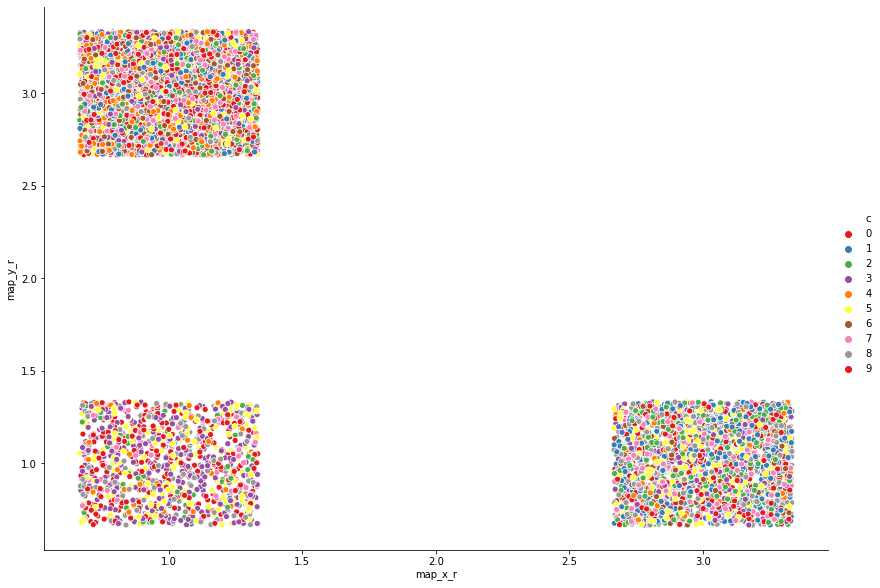

In [714]:
sns.relplot(x="map_x_r",y="map_y_r",hue="c",data=test3,kind="scatter",palette=sns.color_palette("Set1", 10), height=8.27, aspect=11.7/8.27)

Podobnie jak w przypadku sześciokątnej siatki. Mamy tylko 3 klastry.

## Czystość w zależności od neuronu

<Figure size 1800x2880 with 0 Axes>

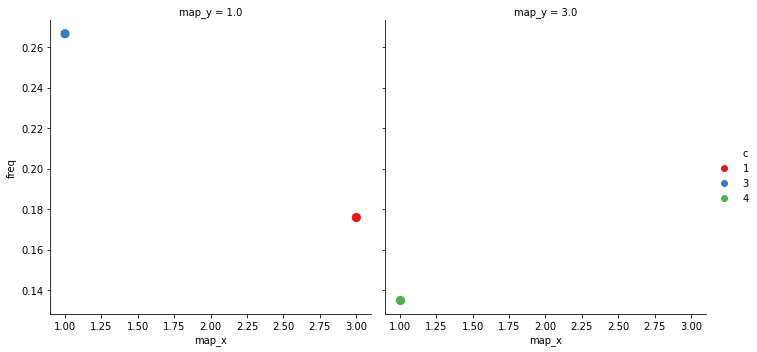

In [715]:
plt.figure(figsize=(25,40))
sns.relplot(x="map_x",y="freq",hue="c",col="map_y",data=t1_square_sombrero,kind="scatter",palette=sns.color_palette("Set1", t1_square_sombrero.c.unique().shape[0]), s=100,col_wrap=2)

3 też zostało najlepiej dopasowane.

## U Macierz

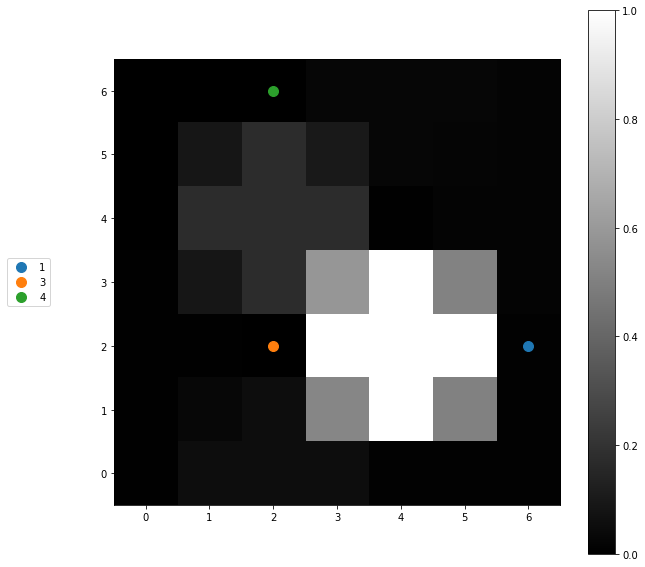

In [716]:
plt.figure(figsize=(10,10))
plt.gray()
plt.imshow(Map_square_sombrero.map_umatrix(statistic="median").T)
for i in np.sort(t1_square_sombrero.c.unique()):
    plt.scatter(t1_square_sombrero[t1_square_sombrero.c==i].map_x.to_numpy()*2,t1_square_sombrero[t1_square_sombrero.c==i].map_y.to_numpy()*2,s=100,label=i)
plt.legend(loc='center left', bbox_to_anchor=(-0.25, 0.5)) 
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

Tutaj neuron [2,1] został "odepchnięty" tak mocno że zmienił "kolorystykę" całej u macierzy. Klastry "działające" też są od siebie wyraźnie odseparowane, to znaczy że żaden ze sobą nie sąsiadował indeksowo jak to miało miejsce dla architektury sześciokątnej.

## Podsumowanie

<Figure size 1800x2880 with 0 Axes>

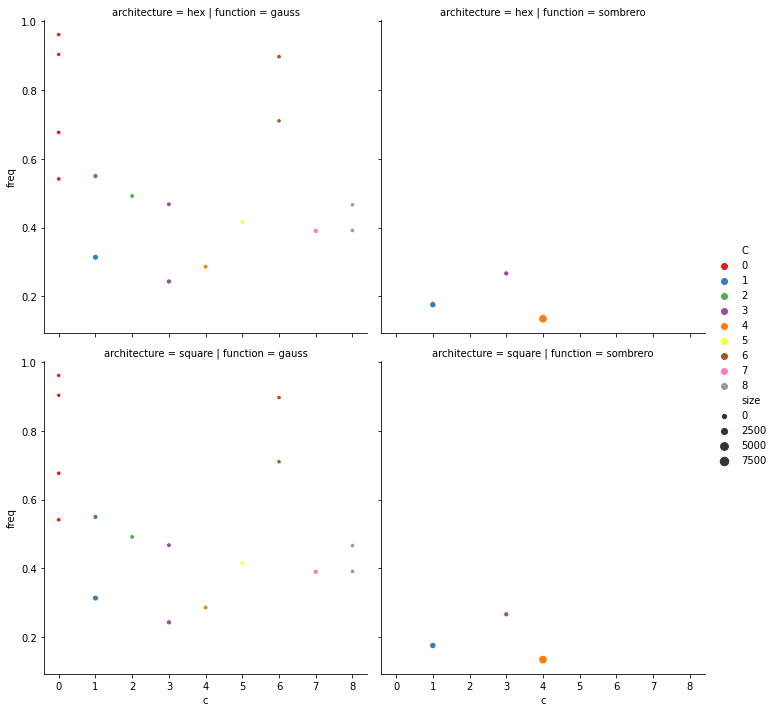

In [717]:
t1_hex_gauss["function"]="gauss"
t1_hex_gauss["architecture"]="hex"
t1_hex_sombrero["function"]="sombrero"
t1_hex_sombrero["architecture"]="hex"
t1_square_gauss["function"]="gauss"
t1_square_gauss["architecture"]="square"
t1_square_sombrero["function"]="sombrero"
t1_square_sombrero["architecture"]="square"

t1_all=pd.concat([t1_hex_gauss,t1_hex_sombrero,t1_square_gauss,t1_square_sombrero])

t1_all=t1_all.reset_index()
t1_all["C"]=t1_all.c
t1_all["c"]=t1_all.c.astype(int)
plt.figure(figsize=(25,40))
sns.relplot(x="c",y="freq",col="function",row="architecture",data=t1_all,kind="scatter", size="size",palette=sns.color_palette("Set1", t1_all.c.unique().shape[0]),hue="C")

Obie architektury dają bardzo podobne rezultaty po dużej liczbie iteracji, zaś funkcja sombrero źle się zachowuje. Po za tym dla tego zbioru danych niektóre klasy są lepiej separowalne od innych. W przypadku funkcji gaussa nawet w najgorszym przypadku podział był lepszy niż losowy.

## UCI HAR

In [718]:
uci_test=pd.read_csv("UCI_HAR/test.csv")

In [719]:
uci_train=pd.read_csv("UCI_HAR/train.csv")

In [720]:
X1 = np.loadtxt("UCI_HAR/train.csv", delimiter=',',skiprows=1,usecols=np.arange(0,561))
Y1 = np.loadtxt("UCI_HAR/train.csv", delimiter=',',skiprows=1,usecols=562,dtype="str")
np.random.seed(123)
np.random.shuffle(X1)
np.random.seed(123)
np.random.shuffle(Y1)
Y1=Y1.reshape(-1,1)

In [721]:
X1_t = np.loadtxt("UCI_HAR/test.csv", delimiter=',',skiprows=1,usecols=np.arange(0,561))
Y1_t = np.loadtxt("UCI_HAR/test.csv", delimiter=',',skiprows=1,usecols=562,dtype="str")
np.random.seed(123)
np.random.shuffle(X1_t)
np.random.seed(123)
np.random.shuffle(Y1_t)
Y1_t=Y1_t.reshape(-1,1)

## Sześciokątna i gaussowska

In [722]:
Map_hex_gauss=Kohen(4,4)

Map_hex_gauss.train(X1[::10,:],100,gaussian,exp_res,hexagon_grid=True)

map_neurons=Map_hex_gauss.map_input(X1_t)

uci=pd.DataFrame(map_neurons,columns=["map_x","map_y"])

uci["map_x_r"]=map_neurons[:,0]+(np.random.random(uci.shape[0])*2-1)/3

uci["map_y_r"]=map_neurons[:,1]+(np.random.random(uci.shape[0])*2-1)/3

uci["c"]=Y1_t[:,0]

k1_hex_gauss=uci.groupby(["map_x","map_y"])["c"].agg(lambda x:x.value_counts().index[0]).reset_index()

t2=uci.groupby(["map_x","map_y"])["c"].agg(lambda x:x.value_counts().nlargest(n=1).values[0]).reset_index()

t3=uci.groupby(["map_x","map_y"])["c"].size().reset_index()

k1_hex_gauss["freq"]=t2.c/t3.c
k1_hex_gauss["size"]=t3.c

## Klasa i BMU dla każdej obserwacji testowej

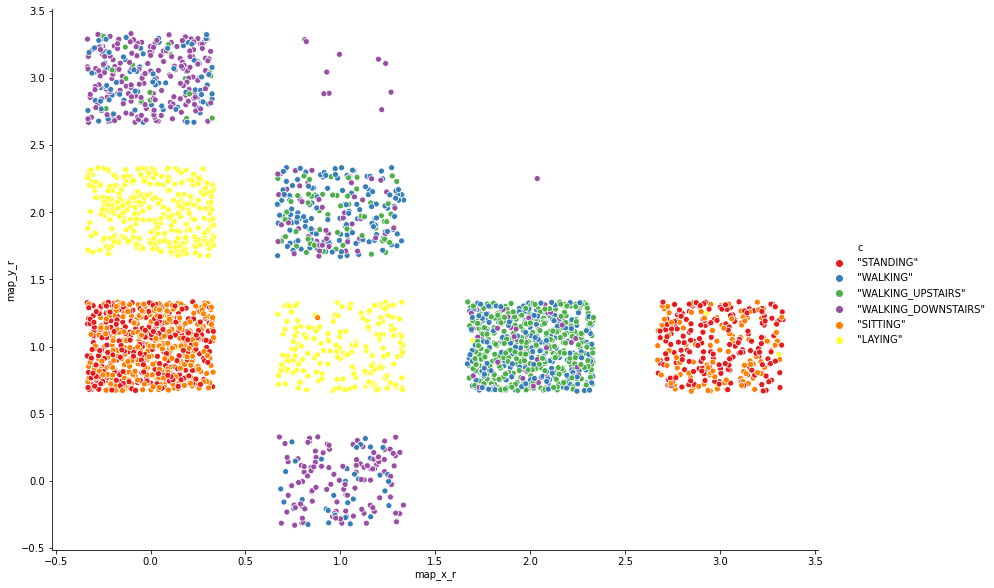

In [723]:
sns.relplot(x="map_x_r",y="map_y_r",hue="c",data=uci,kind="scatter",palette=sns.color_palette("Set1", 6), height=8.27, aspect=11.7/8.27)

Tutaj mamy bardzo dobrą separację dla leżenia. Jest prawie zupełnie czysta. Po za tym czynności są mieszane tylko z pewnymi innymi czynnościami: stanie z siedzeniem, oraz chodzenie w górę w dół i po prostu.

## Czystość w zależności od neuronu

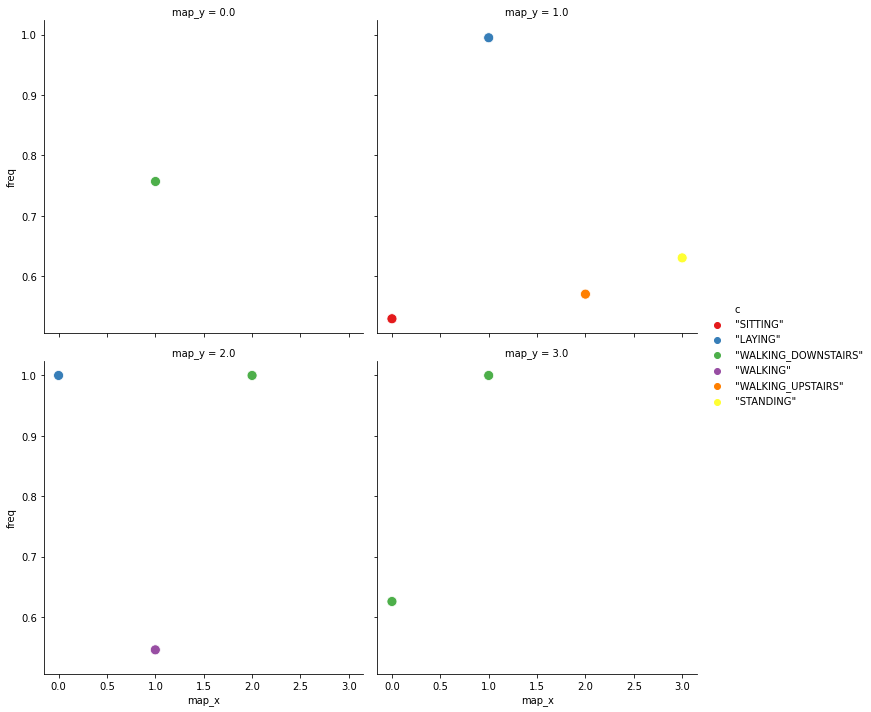

In [724]:
sns.relplot(x="map_x",y="freq",hue="c",col="map_y",data=k1_hex_gauss,kind="scatter",palette=sns.color_palette("Set1", k1_hex_gauss.c.unique().shape[0]), s=100,col_wrap=2)

Leżenie jest prawie czystę, zaś reszta czynności ma czystość powyżej 0.5. Czystość schodzenia w dół w przypadkach [2,2] i [1,3] wynika z małego rozmiaru klastru.

## U Macierz

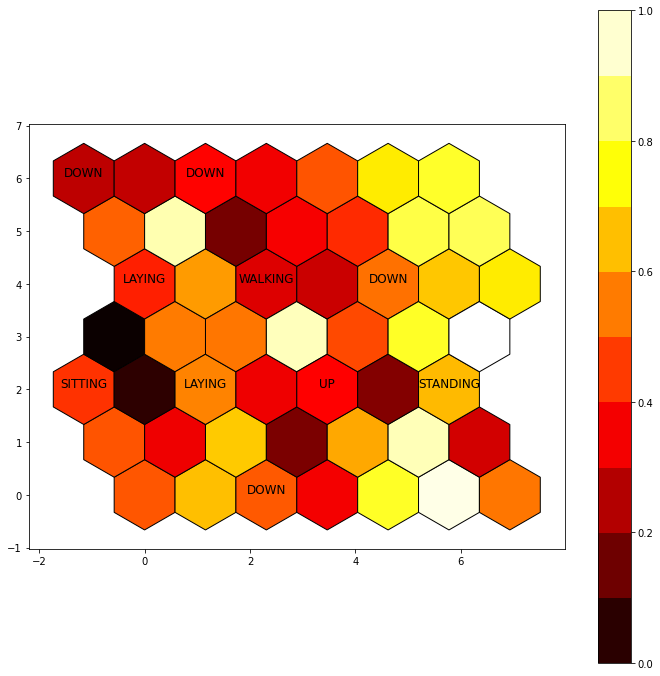

In [725]:
output=np.zeros(((2*len(Map_hex_gauss.Neurons)-1)*(2*len(Map_hex_gauss.Neurons[0])-1),2))
i=0
for x in range((2*len(Map_hex_gauss.Neurons)-1)):
        for y in range((2*len(Map_hex_gauss.Neurons[0])-1)):
            output[i,0]=x
            output[i,1]=y
            i+=1

output[output[:,1]%7==2,0]=output[output[:,1]%7==2,0]-1

output[output[:,1]%7==6,0]=output[output[:,1]%7==6,0]-1
            
hexy=Map_hex_gauss.hexagonal_cord(output)

kolor=Map_hex_gauss.map_umatrix_hex()

kolor=kolor.reshape(1,-1)[0]

numbers=k1_hex_gauss[["map_x","map_y"]].to_numpy()*2

numbers[numbers[:,1]%7==2,0]=numbers[numbers[:,1]%7==2,0]-1

numbers[numbers[:,1]%7==6,0]=numbers[numbers[:,1]%7==6,0]-1

numbers=Map_hex_gauss.hexagonal_cord(numbers)

coord = hexy
colors = kolor

colors=(colors-np.min(colors))/(np.max(colors)-np.min(colors))

# Horizontal cartesian coords
hcoord = [c[0] for c in coord]

# Vertical cartersian coords
vcoord = [2. * np.sin(np.radians(60)) * (c[1] - c[2]) /3. for c in coord]

hcoord2=[np.cos(np.radians(-30))*hcoord[x]+np.sin(np.radians(-30))*vcoord[x] for x in range(len(hcoord))]
vcoord2=[-np.sin(np.radians(-30))*hcoord[x]+np.cos(np.radians(-30))*vcoord[x] for x in range(len(hcoord))]

hcoord=hcoord2
vcoord=vcoord2

fig, ax = plt.subplots(1,figsize=(12,12))
ax.set_aspect('equal')
  
# Add some coloured hexagons
for x, y, c in zip(hcoord, vcoord, colors):
    color = cm.hot(c) # matplotlib understands lower case words for colours
    hex = RegularPolygon((x, y), numVertices=6, radius=2. / 3., 
                         orientation=np.radians(60), 
                         facecolor=color, edgecolor='k')
    ax.add_patch(hex)

ax.scatter(hcoord, vcoord, c=[cm.hot(c) for c in colors])

coord = numbers
# Horizontal cartesian coords
hcoord = [c[0] for c in coord]
# Vertical cartersian coords
vcoord = [2. * np.sin(np.radians(60)) * (c[1] - c[2]) /3. for c in coord]

hcoord2=[np.cos(np.radians(-30))*hcoord[x]+np.sin(np.radians(-30))*vcoord[x] for x in range(len(hcoord))]
vcoord2=[-np.sin(np.radians(-30))*hcoord[x]+np.cos(np.radians(-30))*vcoord[x] for x in range(len(hcoord))]

hcoord=hcoord2
vcoord=vcoord2
i=0
for x, y in zip(hcoord, vcoord):
    if k1_hex_gauss.c[i].find("DOWN")!=-1:
        ax.text(x, y+0.1, "DOWN", ha='center', va='center', size=12)
    elif k1_hex_gauss.c[i].find("UPS")!=-1:
        ax.text(x, y+0.1, "UP", ha='center', va='center', size=12)
    else:
        ax.text(x, y+0.1, k1_hex_gauss.c[i].strip("\""), ha='center', va='center', size=12)
    i+=1

sm = plt.cm.ScalarMappable(cmap=cm.hot)
sm.set_array([])
plt.colorbar(sm, boundaries=np.arange(0,1.1,.1))


Umacierz pokazuje podobieństwa pomiędzy siedzeniem, a leżeniem i separację pomiędzy staniem, a schodzeniem w dół. Widzimy też podobieństwo między schodzeniem w dół, a chodzeniem.

## Sześciokątna i sombrero

In [726]:
Map_hex_sombrero=Kohen(4,4)

Map_hex_sombrero.train(X1[::10,:],100,mexican_hat,exp_res,hexagon_grid=True)

map_neurons=Map_hex_sombrero.map_input(X1_t)

uci1=pd.DataFrame(map_neurons,columns=["map_x","map_y"])

uci1["map_x_r"]=map_neurons[:,0]+(np.random.random(uci.shape[0])*2-1)/3

uci1["map_y_r"]=map_neurons[:,1]+(np.random.random(uci.shape[0])*2-1)/3

uci1["c"]=Y1_t[:,0]

k1_hex_sombrero=uci1.groupby(["map_x","map_y"])["c"].agg(lambda x:x.value_counts().index[0]).reset_index()

t2=uci1.groupby(["map_x","map_y"])["c"].agg(lambda x:x.value_counts().nlargest(n=1).values[0]).reset_index()

t3=uci1.groupby(["map_x","map_y"])["c"].size().reset_index()

k1_hex_sombrero["freq"]=t2.c/t3.c
k1_hex_sombrero["size"]=t3.c

## Klasa i BMU dla każdej obserwacji testowej

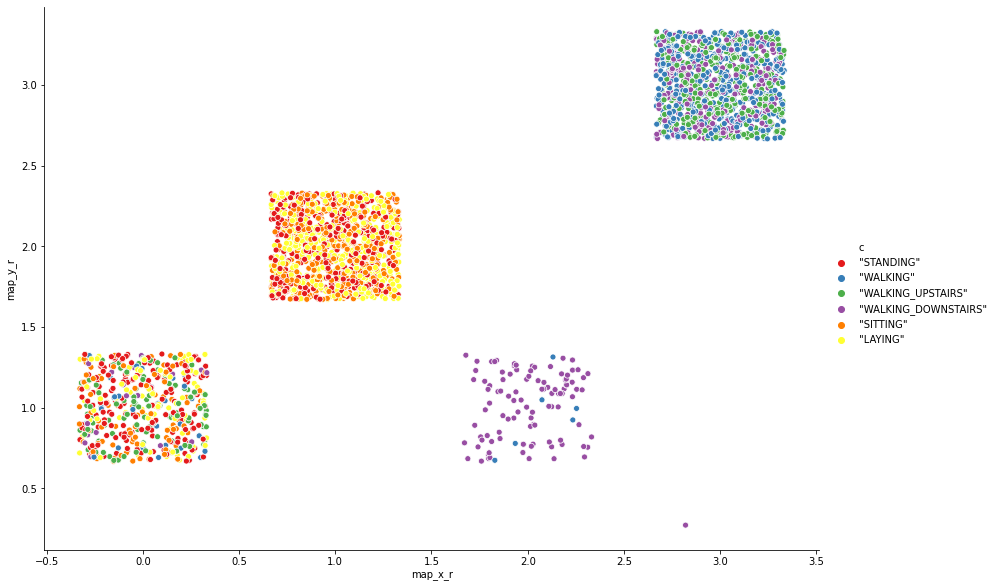

In [727]:
sns.relplot(x="map_x_r",y="map_y_r",hue="c",data=uci1,kind="scatter",palette=sns.color_palette("Set1", 6), height=8.27, aspect=11.7/8.27)

Zła liczba klastrów. Ale są klastry aktywności ruchowych i pasywnych. Wykryto też dwa czyste klastry shodzenia w dół. Klaster [0,1] jest wymieszany

## Czystość w zależności od neuronu

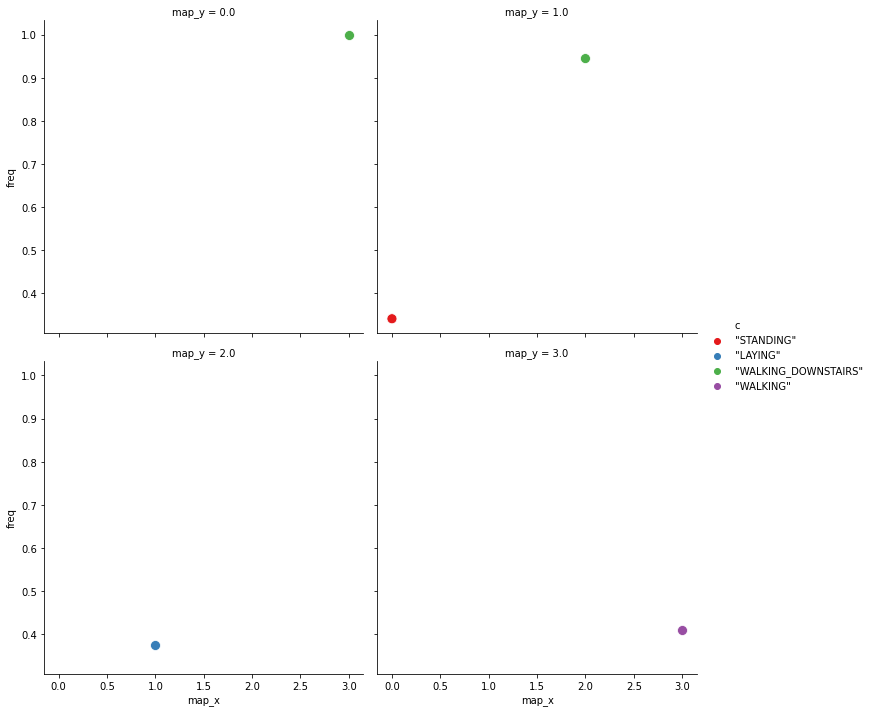

In [728]:
sns.relplot(x="map_x",y="freq",hue="c",col="map_y",data=k1_hex_sombrero,kind="scatter",palette=sns.color_palette("Set1", k1_hex_sombrero.c.unique().shape[0]), s=100,col_wrap=2)

Oprócz dwóch małych klastrów schodzenia w dół to pozostałe mają małą czystość.

## U Macierz

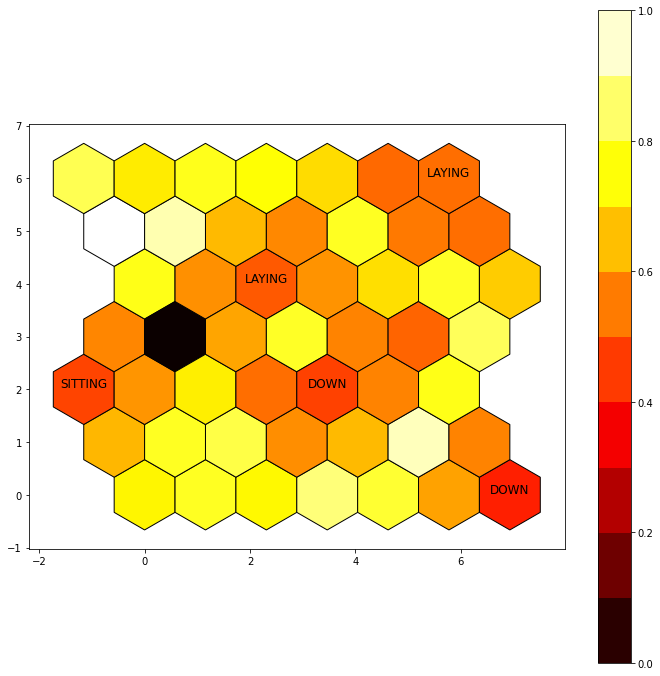

In [729]:
output=np.zeros(((2*len(Map_hex_sombrero.Neurons)-1)*(2*len(Map_hex_sombrero.Neurons[0])-1),2))
i=0
for x in range((2*len(Map_hex_sombrero.Neurons)-1)):
        for y in range((2*len(Map_hex_sombrero.Neurons[0])-1)):
            output[i,0]=x
            output[i,1]=y
            i+=1

output[output[:,1]%7==2,0]=output[output[:,1]%7==2,0]-1

output[output[:,1]%7==6,0]=output[output[:,1]%7==6,0]-1
            
hexy=Map_hex_sombrero.hexagonal_cord(output)

kolor=Map_hex_sombrero.map_umatrix_hex()

kolor=kolor.reshape(1,-1)[0]

numbers=k1_hex_sombrero[["map_x","map_y"]].to_numpy()*2

numbers[numbers[:,1]%7==2,0]=numbers[numbers[:,1]%7==2,0]-1

numbers[numbers[:,1]%7==6,0]=numbers[numbers[:,1]%7==6,0]-1

numbers=Map_hex_sombrero.hexagonal_cord(numbers)

coord = hexy
colors = kolor

colors=(colors-np.min(colors))/(np.max(colors)-np.min(colors))

# Horizontal cartesian coords
hcoord = [c[0] for c in coord]

# Vertical cartersian coords
vcoord = [2. * np.sin(np.radians(60)) * (c[1] - c[2]) /3. for c in coord]

hcoord2=[np.cos(np.radians(-30))*hcoord[x]+np.sin(np.radians(-30))*vcoord[x] for x in range(len(hcoord))]
vcoord2=[-np.sin(np.radians(-30))*hcoord[x]+np.cos(np.radians(-30))*vcoord[x] for x in range(len(hcoord))]

hcoord=hcoord2
vcoord=vcoord2

fig, ax = plt.subplots(1,figsize=(12,12))
ax.set_aspect('equal')
  
# Add some coloured hexagons
for x, y, c in zip(hcoord, vcoord, colors):
    color = cm.hot(c) # matplotlib understands lower case words for colours
    hex = RegularPolygon((x, y), numVertices=6, radius=2. / 3., 
                         orientation=np.radians(60), 
                         facecolor=color, edgecolor='k')
    ax.add_patch(hex)

ax.scatter(hcoord, vcoord, c=[cm.hot(c) for c in colors])

coord = numbers
# Horizontal cartesian coords
hcoord = [c[0] for c in coord]
# Vertical cartersian coords
vcoord = [2. * np.sin(np.radians(60)) * (c[1] - c[2]) /3. for c in coord]

hcoord2=[np.cos(np.radians(-30))*hcoord[x]+np.sin(np.radians(-30))*vcoord[x] for x in range(len(hcoord))]
vcoord2=[-np.sin(np.radians(-30))*hcoord[x]+np.cos(np.radians(-30))*vcoord[x] for x in range(len(hcoord))]

hcoord=hcoord2
vcoord=vcoord2
i=0
for x, y in zip(hcoord, vcoord):
    if k1_hex_gauss.c[i].find("DOWN")!=-1:
        ax.text(x, y+0.1, "DOWN", ha='center', va='center', size=12)
    elif k1_hex_gauss.c[i].find("UPS")!=-1:
        ax.text(x, y+0.1, "UP", ha='center', va='center', size=12)
    else:
        ax.text(x, y+0.1, k1_hex_gauss.c[i].strip("\""), ha='center', va='center', size=12)
    i+=1

sm = plt.cm.ScalarMappable(cmap=cm.hot)
sm.set_array([])
plt.colorbar(sm, boundaries=np.arange(0,1.1,.1))


Klastry są od siebie odległe

## Kwadratowa i gaussowska

In [730]:
Map_square_gauss=Kohen(4,4)

Map_square_gauss.train(X1[::10,:],100,gaussian,exp_res,hexagon_grid=False)

map_neurons=Map_square_gauss.map_input(X1_t)

uci2=pd.DataFrame(map_neurons,columns=["map_x","map_y"])

uci2["map_x_r"]=map_neurons[:,0]+(np.random.random(uci.shape[0])*2-1)/3

uci2["map_y_r"]=map_neurons[:,1]+(np.random.random(uci.shape[0])*2-1)/3

uci2["c"]=Y1_t[:,0]

k1_square_gauss=uci2.groupby(["map_x","map_y"])["c"].agg(lambda x:x.value_counts().index[0]).reset_index()

t2=uci2.groupby(["map_x","map_y"])["c"].agg(lambda x:x.value_counts().nlargest(n=1).values[0]).reset_index()

t3=uci2.groupby(["map_x","map_y"])["c"].size().reset_index()

k1_square_gauss["freq"]=t2.c/t3.c
k1_square_gauss["size"]=t3.c

## Klasa i BMU dla każdej obserwacji testowej

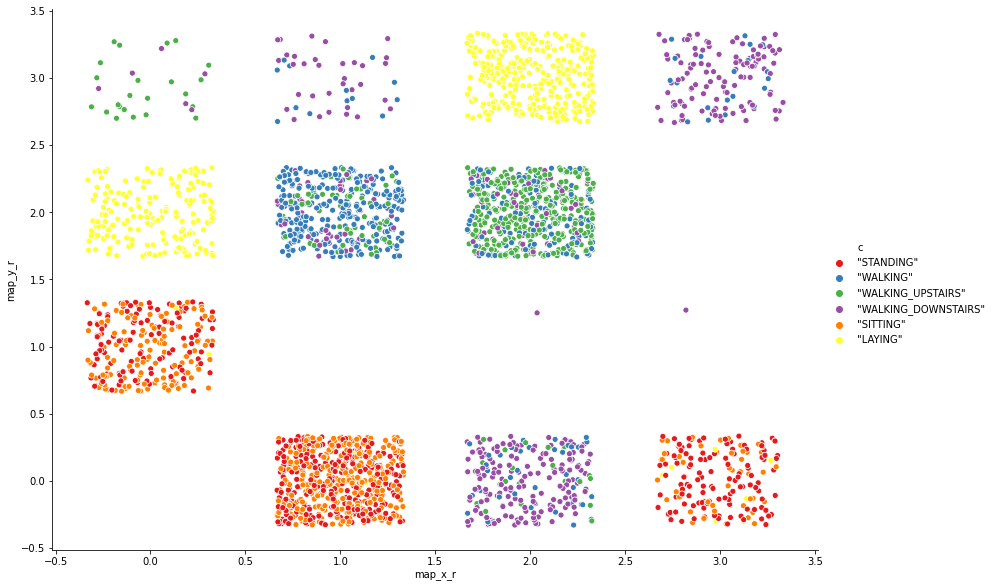

In [731]:
sns.relplot(x="map_x_r",y="map_y_r",hue="c",data=uci2,kind="scatter",palette=sns.color_palette("Set1", 6), height=8.27, aspect=11.7/8.27)

Podobne wyniki do architektury sześciokątnej. Liczba klastrów jest jednak nieco inna.

## Czystość w zależności od neuronu

<Figure size 1800x2880 with 0 Axes>

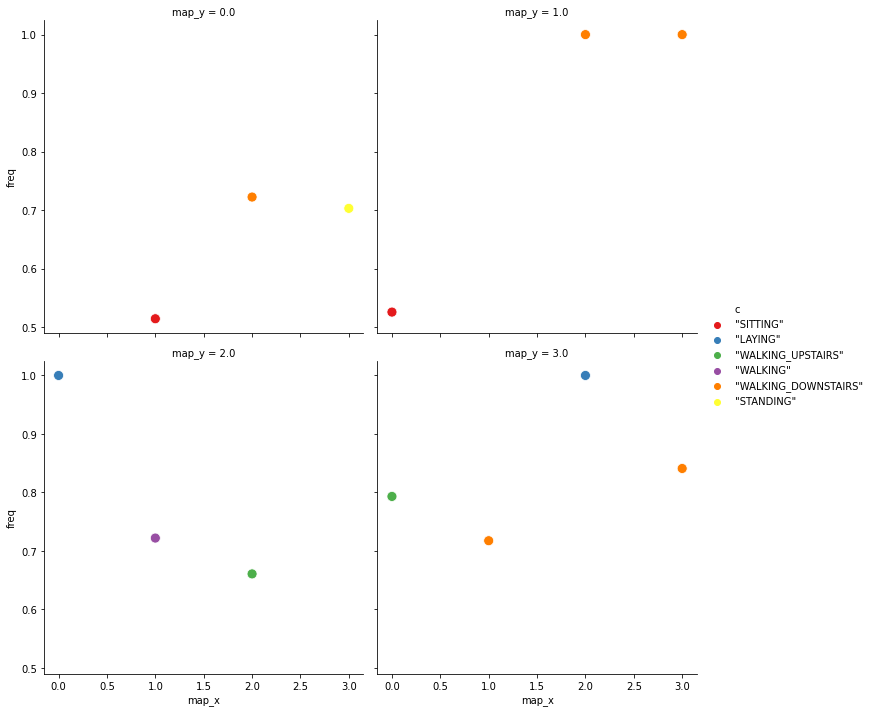

In [732]:
plt.figure(figsize=(25,40))
sns.relplot(x="map_x",y="freq",hue="c",col="map_y",data=k1_square_gauss,kind="scatter",palette=sns.color_palette("Set1", k1_square_gauss.c.unique().shape[0]), s=100,col_wrap=2)

Leżenie jest prawie czystę, zaś reszta czynności ma czystość powyżej 0.5. Czystość schodzenia w dół w przypadkach [2,1] i [3,1] wynika z małego rozmiaru klastru.

## U Macierz

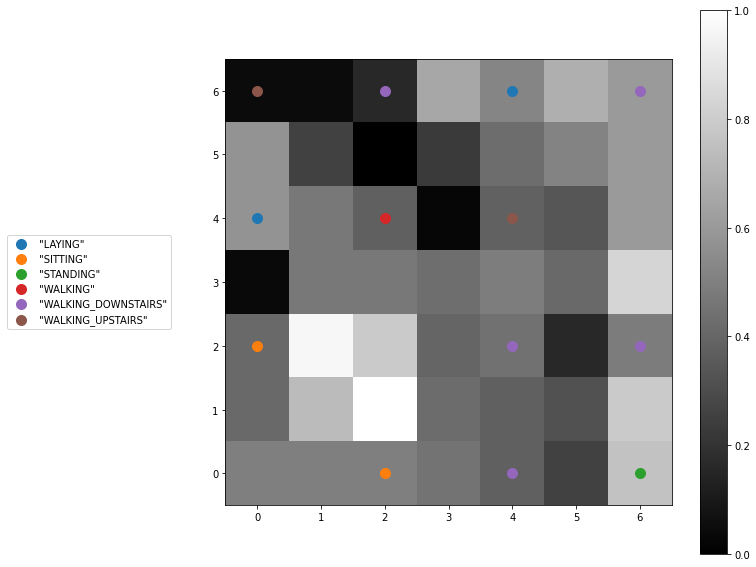

In [733]:
plt.figure(figsize=(10,10))
plt.gray()
plt.imshow(Map_square_gauss.map_umatrix(statistic="median").T)
for i in np.sort(k1_square_gauss.c.unique()):
    plt.scatter(k1_square_gauss[k1_square_gauss.c==i].map_x.to_numpy()*2,k1_square_gauss[k1_square_gauss.c==i].map_y.to_numpy()*2,s=100,label=i)
plt.legend(loc='center left', bbox_to_anchor=(-0.5, 0.5)) 
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

Siedzenie jest podobne do leżenia, zaś aktywności ruchowe są do siebie podobne.

## Kwadratowa i sombrero

In [734]:
Map_square_sombrero=Kohen(4,4)

Map_square_sombrero.train(X1[::10,:],100,mexican_hat,exp_res,hexagon_grid=False)

map_neurons=Map_square_sombrero.map_input(X1_t)

uci3=pd.DataFrame(map_neurons,columns=["map_x","map_y"])

uci3["map_x_r"]=map_neurons[:,0]+(np.random.random(uci.shape[0])*2-1)/3

uci3["map_y_r"]=map_neurons[:,1]+(np.random.random(uci.shape[0])*2-1)/3

uci3["c"]=Y1_t[:,0]

k1_square_sombrero=uci3.groupby(["map_x","map_y"])["c"].agg(lambda x:x.value_counts().index[0]).reset_index()

t2=uci3.groupby(["map_x","map_y"])["c"].agg(lambda x:x.value_counts().nlargest(n=1).values[0]).reset_index()

t3=uci3.groupby(["map_x","map_y"])["c"].size().reset_index()

k1_square_sombrero["freq"]=t2.c/t3.c
k1_square_sombrero["size"]=t3.c

## Klasa i BMU dla każdej obserwacji testowej

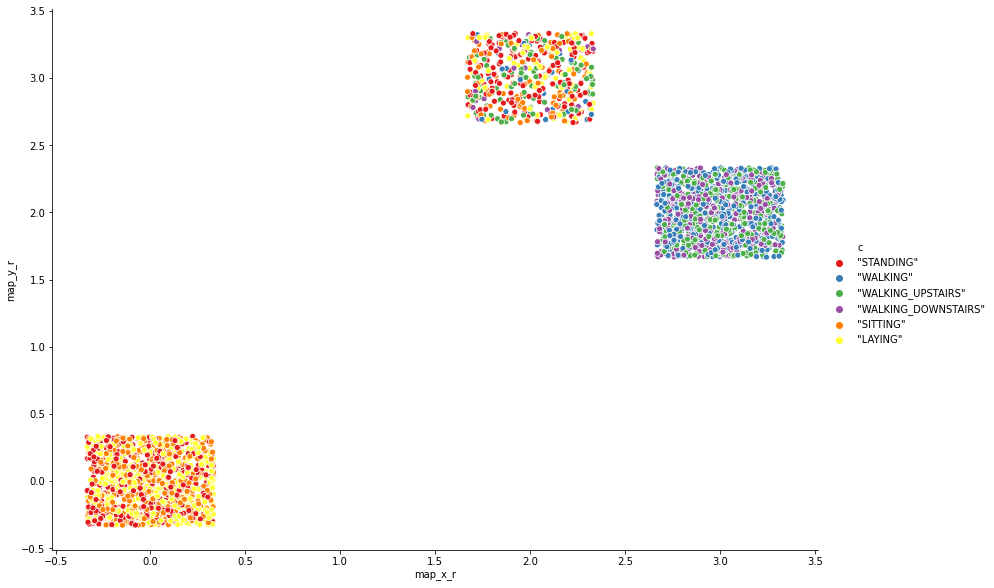

In [735]:
sns.relplot(x="map_x_r",y="map_y_r",hue="c",data=uci3,kind="scatter",palette=sns.color_palette("Set1", 6), height=8.27, aspect=11.7/8.27)

Mamy 3 klastry: jeden mieszany, jeden aktywności ruchowych i jeden aktywności pasywnych.

## Czystość w zależności od neuronu

<Figure size 1800x2880 with 0 Axes>

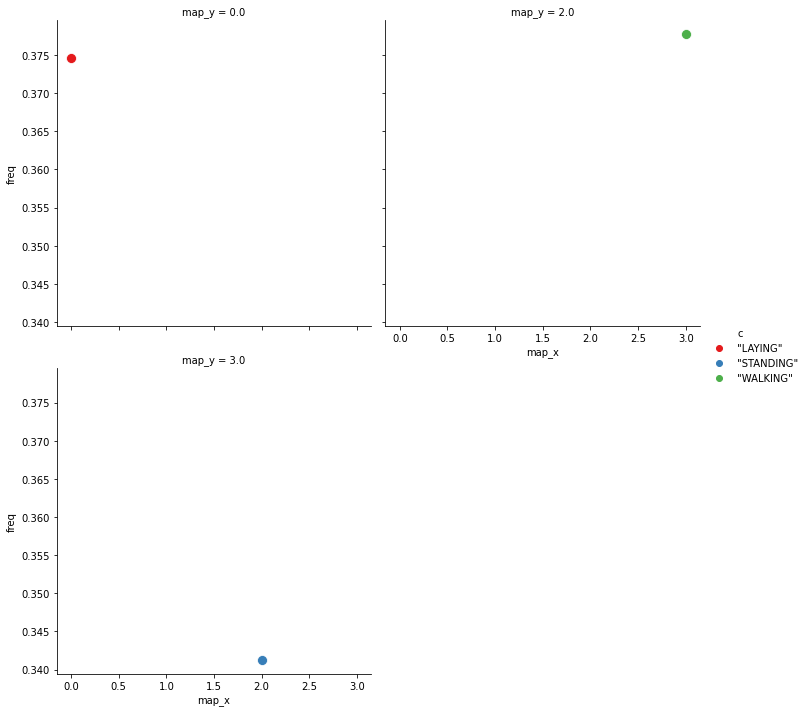

In [736]:
plt.figure(figsize=(25,40))
sns.relplot(x="map_x",y="freq",hue="c",col="map_y",data=k1_square_sombrero,kind="scatter",palette=sns.color_palette("Set1", k1_square_sombrero.c.unique().shape[0]), s=100,col_wrap=2)

Wszystkie mają czystość lepszą od 0.34 ale gorszą od 0.4 co sugeruję że klasy w klastrach aktywności ruchowych i pasywnych są równomiernie rozłożone.

## U Macierz

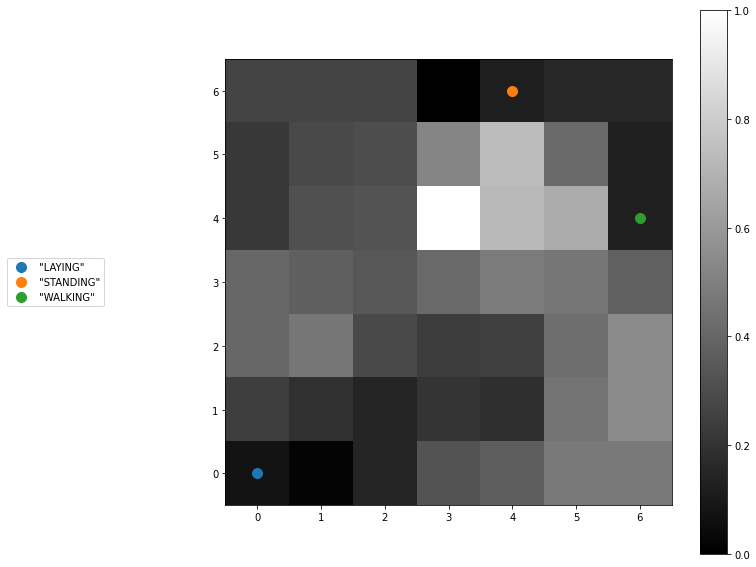

In [737]:
plt.figure(figsize=(10,10))
plt.gray()
plt.imshow(Map_square_sombrero.map_umatrix(statistic="median").T)
for i in np.sort(k1_square_sombrero.c.unique()):
    plt.scatter(k1_square_sombrero[k1_square_sombrero.c==i].map_x.to_numpy()*2,k1_square_sombrero[k1_square_sombrero.c==i].map_y.to_numpy()*2,s=100,label=i)
plt.legend(loc='center left', bbox_to_anchor=(-0.5, 0.5)) 
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

Mamy tu też do czynienia ze zjawiskiem "odepchnięcia" tutaj neuronu [2,2]. mamy też wyrażny podział między leżeniem, a resztą aktywności.

## Podsumowanie

<Figure size 1800x2880 with 0 Axes>

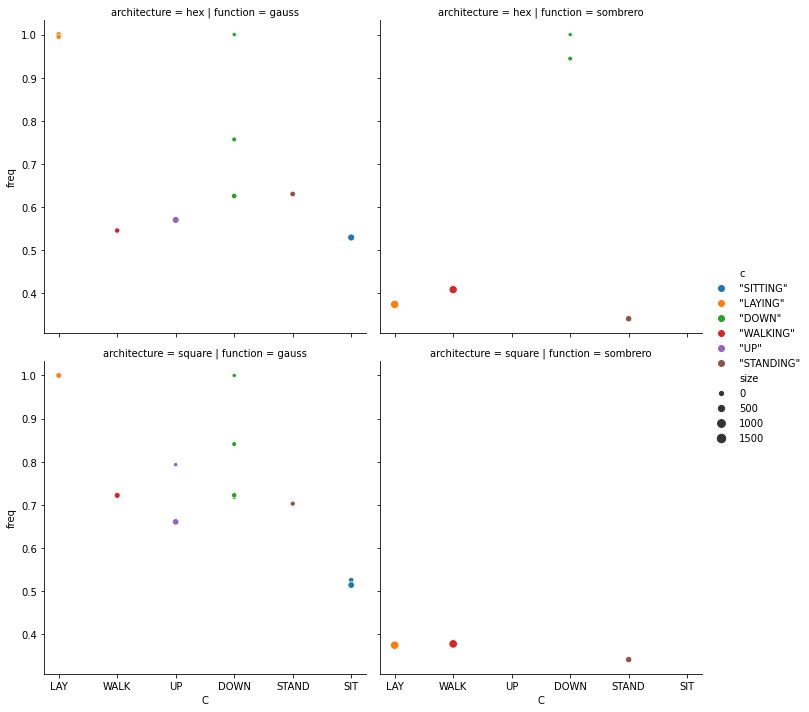

In [738]:
k1_hex_gauss["function"]="gauss"
k1_hex_gauss["architecture"]="hex"
k1_hex_sombrero["function"]="sombrero"
k1_hex_sombrero["architecture"]="hex"
k1_square_gauss["function"]="gauss"
k1_square_gauss["architecture"]="square"
k1_square_sombrero["function"]="sombrero"
k1_square_sombrero["architecture"]="square"

k1_all=pd.concat([k1_hex_gauss,k1_hex_sombrero,k1_square_gauss,k1_square_sombrero])

k1_all=k1_all.reset_index()

k1_all.loc[k1_all.c=="\"WALKING_DOWNSTAIRS\"","c"]="\"DOWN\""

k1_all.loc[k1_all.c=="\"WALKING_UPSTAIRS\"","c"]="\"UP\""

k1_all["C"]=k1_all.c

dic = {'\"LAYING\"':1, '\"WALKING\"':2, '\"UP\"':3, '\"DOWN\"':4,
               '\"STANDING\"':5, '\"SITTING\"':6}

k1_all["C"]=k1_all["C"].apply(lambda x: dic.get(x))

x_ticks_labels = ['LAY','LAY', 'WALK', 'UP', 'DOWN',
               'STAND', 'SIT']

plt.figure(figsize=(25,40))
sns.relplot(x="C",y="freq",col="function",row="architecture",data=k1_all,kind="scatter", size="size",hue="c").set_xticklabels(x_ticks_labels, rotation='horizontal', fontsize=10)

Tutaj w przypadku funkcji gaussa architektura kwadratowa okazała się lepsza od sześciokątnej. Zaś w przypadku funkcji sombrero jest na odwrót: architektura sześciokątna okazała się lepsza od kwadratowej. Po za tym to funkcja gaussa jest zdecydowanie lepsza od sombrero.

# Ogólne wnioski

Funkcja sombrero poprzez możliwość otrzymywania ujemnych wartości może doprowadzić do dziwnych zachowań, więc odradzam jej używania. Architektura kwadratowa okazała się nie gorsza od sześciokątnej, ale ponieważ podania zostały wykonane tylko na dwóch zbiorach danych to jeszcze nie przesądza o jej wyższości nad sześciokątną. Po za tym okazało się że są klasy w zbiorach danych które są łatwiej separowalne od innych i to niezależnie od architektury.